## Recipe Ingredient Analysis Notebook

### Objectives and Approach

In this notebook, I will work on analyzing ingredients from a Spanish recipe dataset with the following goals:

- **Identify whether a given word or phrase is an ingredient or not**, using a combination of rule-based checks and embedding-based similarity.
- **Detect duplicate ingredients** that appear in different forms (e.g., gender variations like *quemado/quemada*, singular/plural forms) to clean and consolidate the ingredient list.
- **Find substitute or similar ingredients** by leveraging word embeddings, helping with recipe modification or alternative recommendations.
- **Create meaningful categories or clusters of ingredients** to organize them better (e.g., spices, vegetables, dairy).

The code will be designed modularly, allowing us to switch between different embedding models or techniques easily.  
Initially, I will use a **custom-trained Word2Vec model** built on our Spanish recipe corpus to capture the semantic relationships between ingredients.


In [207]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin


import gensim

In [172]:
# Load the embedding model (assuming it's a Word2Vec model saved as 'w2v_ngram.model')
embedding_model = gensim.models.Word2Vec.load('models/w2v_ngram.model')

def get_embeddings(words, model=embedding_model):
    """
    Returns a list of embeddings for the given list of words.
    If a word is not in the vocabulary, returns None for that word.
    """
    embeddings = {}
    for word in words:
        # convert any spaces to '_' example 'pimiento rojo' = 'pimiento_rojo'
        word = word.replace(' ','_')
        if word in model.wv:
            embeddings[word] = (model.wv[word])
    
    res = pd.DataFrame.from_dict(embeddings, orient= 'index')
    return res.reindex(words).to_numpy()

get_embeddings(['harina', 'pimentón_dulce', 'ponla'], embedding_model).shape

(3, 300)

### Ingredient Classification: Yes or No?

This section focuses on building a classification model to determine whether a given word or n-gram represents an **ingredient** or **not**.

We will experiment with the following models:

- **Logistic Regression**: A strong baseline for binary classification that performs well with high-dimensional data.
- **Random Forest**: Provides good generalization and handles non-linear relationships, helping with noisy or imperfect labels.

### Why we're not using:
- **Naive Bayes** – cannot handle dense, real-valued embeddings (like Word2Vec or FastText), and violates the independence assumption.
- **K-Nearest Neighbors (KNN)**: Too slow for prediction on large, imbalanced datasets.
- **Support Vector Machines (SVM)**: Not ideal for large datasets and may struggle when classes aren't linearly separable.
- **Decision Trees**: Prone to overfitting, especially with noisy labels.

### Considerations:
- Our training dataset was **manually labeled**, so it's crucial the model is **robust to mislabeled examples** or outliers.
- Evaluation will include manual inspection of edge cases and common mistakes.

### Test Cases:
- `"harina de trigo"` → ingredient  
- `"precalentar el horno"` → not an ingredient  
- `"queso rallado"` → ingredient  
- `"batir los huevos"` → not an ingredient  

In [173]:
data =pd.read_csv("data/is_ingrediente.csv").rename(columns = {'Unnamed: 0':'word'})
data.sample(6)

,word,is_ingrediente
10592,especiada,False
9116,coloques,False
644,de_oliva_virgen,True
3538,pocas_calorías,False
312,queso_crema,True
4885,lugar_cálido,False


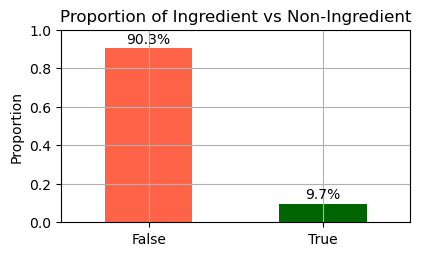

In [174]:
plt.figure(figsize= (4.5,2.5))
data['is_ingrediente'].value_counts(normalize=True).plot(
    kind='bar',
    color=['tomato', 'darkgreen'],
    rot=0
)
plt.title('Proportion of Ingredient vs Non-Ingredient')
plt.xlabel(None)
plt.ylabel('Proportion')
plt.xticks([0, 1], ['False', 'True'])
plt.ylim((0,1))

# Add text labels to each bar
for i, v in enumerate(data['is_ingrediente'].value_counts(normalize=True)):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom', fontsize= 10)

plt.grid()
plt.show()


In [175]:
class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that converts a list of words/phrases
    to their embedding vectors using a gensim Word2Vec model.
    If a word is not in the model, returns a zero vector of the same dimension.
    """
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is expected to be a list or array of strings
        return get_embeddings(X, self.model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['word'], data['is_ingrediente'].astype(int), test_size= 0.3, 
                                                    stratify= data['is_ingrediente'], random_state= 1)

{'clf__min_samples_split': 5, 'clf__n_estimators': 50}

In [ ]:
logreg_pipe = Pipeline([
    ('embed', EmbeddingVectorizer(embedding_model)),
    ('clf', LogisticRegression())
])
logreg_pipe.fit(X_train, y_train)
print(f"Test Accuracy for Logistic Regression: {100*logreg_pipe.score(X_test, y_test):.1f}%\n")

rf_params = {
    'clf__n_estimators': [50, 100],
    # 'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

rf_pipe = Pipeline([
    ('embed', EmbeddingVectorizer(embedding_model)),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, n_jobs=-1, verbose=1, scoring= 'recall')
rf_grid.fit(X_train, y_train)

print(f"Best RF Params: {rf_grid.best_params_}")

print(f"Test Accuracy for Random Forest: {100*accuracy_score(y_test, rf_grid.predict(X_test)):.1f}%")

Test Accuracy for Logistic Regression: 92.0%

Best RF Params: {'clf__min_samples_split': 5, 'clf__n_estimators': 50}
Test Accuracy for Random Forest: 91.6%


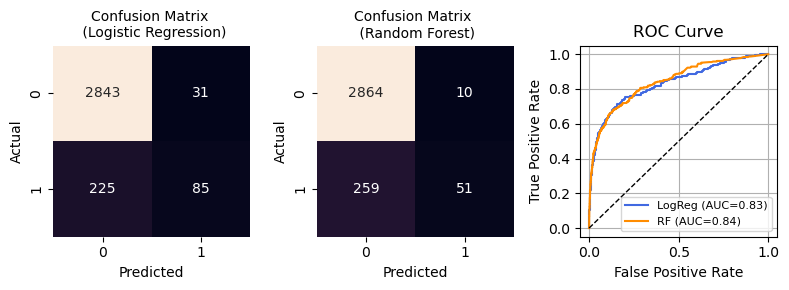

In [225]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

# Logistic Regression confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_pipe.predict(X_test))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='rocket', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix \n (Logistic Regression)', fontsize= 10)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest confusion matrix
rf_cm = confusion_matrix(y_test, rf_grid.predict(X_test))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='rocket', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix \n (Random Forest)', fontsize= 10)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Logistic Regression ROC
y_score_logreg = logreg_pipe.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Random Forest ROC
y_score_rf = rf_grid.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

axes[2].plot(fpr_logreg, tpr_logreg, label=f'LogReg (AUC={roc_auc_logreg:.2f})', color='royalblue')
axes[2].plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_rf:.2f})', color='darkorange')
axes[2].plot([0, 1], [0, 1], 'k--', lw=1)
axes[2].set_title('ROC Curve')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].legend(loc='lower right', fontsize= 8)
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [221]:
tmp = data.loc[X_test.index].copy()
tmp['predict'] = logreg_pipe.predict(X_test)
tmp[tmp['is_ingrediente'] != tmp['predict']].sort_values(['is_ingrediente'])

,word,is_ingrediente,predict
1097,anchoas,False,1
227,manteca,False,1
183,aproximadamente,False,1
1706,guacamole,False,1
2295,granada,False,1
...,...,...,...
1209,clavos,True,0
3555,azúcar_moreno,True,0
10585,empanadilla,True,0
8885,mantequilla_clarificada,True,0


In [222]:
X_demo = ['melón', 'kiwi', 'papaya', 'fresas', 'fresones', 'moras', 'salmón', 'pita', 'crutones', 'ajo', 'salsa', 'hacer', 'quemar',
          'azúcar_moreno', 'chiles_jalapeños', 'frutal', 'clavos', 'tomate_natural', 'azucar']
pd.DataFrame(logreg_pipe.predict_proba(X_demo), index= X_demo)

,0,1
melón,0.840779,0.159221
kiwi,0.909897,0.090103
papaya,0.798573,0.201427
fresas,0.048825,0.951175
fresones,0.923177,0.076823
moras,0.838601,0.161399
salmón,0.094817,0.905183
pita,0.987454,0.012546
crutones,0.881001,0.118999
ajo,0.000154,0.999846
